In [1]:
import cv2
import matplotlib.pyplot as plt
from tkinter import *
from tkinter import ttk
from PIL import Image, ImageTk
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import csv
import os
from datetime import datetime
import sqlite3
import pickle


In [ ]:
X = load_model('mymodel.h5')
ss = pickle.loads(open("ss.pkl", "rb").read())
pca = pickle.loads(open("pca.pkl", "rb").read())
model = pickle.loads(open("oc_svm_fruit.pkl", "rb").read())
image_size = 224

def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    #output = img_array
    output = preprocess_input(img_array)
    return(output)
resnet_model = ResNet50(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False, pooling='avg')
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )
x= []
x.append(['none','/content/7721dbd446fa757a94cb9e34c91f77a3.jpg_2200x2200q80.jpg'])
dftest = pd.DataFrame(x, columns = ["fruit", "path"])
X_train = read_and_prep_images(dftest["path"])
X_train = resnet_model.predict(X_train)
X_train = ss.transform(X_train)
X_train = pca.transform(X_train)

preds = model.predict(X_train)
def predict_fruit(dftest):
  imtest = test_generator.flow_from_dataframe(
        dataframe=dftest,
        x_col='path',
        y_col='fruit',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=1,
        shuffle=False
    )
  ans = X.predict(imtest)
  ans = np.argmax(ans,axis=1)
  return ans
ans = predict_fruit(dftest)
label = ['Apple', 'Banana', 'Carambola', 'Guava', 'Kiwi', 'Mango', 'Orange', 'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Tomatoes', 'Muskmelon']
print("The result prediction is:")
count = 0
for no in ans:
    if(preds[count]>0): 
      print(label[no])
    else:
      print("Unsuitable Image")
    testim = plt.imread(x[count][1])
    plt.imshow(testim)
    plt.title("Original image")
    plt.show()
    count = count + 1


In [2]:
class CaptureObject:
    def __init__(self, video_source):
        self.cap = cv2.VideoCapture(video_source)
        if not self.cap.isOpened():
            raise ValueError("Unable to open video source",video_source)
        self.width = self.cap.get(cv2.CAP_PROP_FRAME_WIDTH)
        self.height = self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
        
    def getFrame(self):
        _, frame = self.cap.read()
        return frame
    
    def releaseVid(self):
        self.cap.release()
           

In [3]:
def predict_image(model, image):
    if image:
        test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
        )

        x = []
        x.append(['none', image])
        dftest = pd.DataFrame(x, columns = ["fruit", "path"])\

        imtest = test_generator.flow_from_dataframe(
                dataframe=dftest,
                x_col='path',
                y_col='fruit',
                target_size=(224, 224),
                color_mode='rgb',
                class_mode='categorical',
                batch_size=1,
                shuffle=False
            )
        type = ""
        ans = model.predict(imtest)
        ans = np.argmax(ans,axis=1)

        label = ['Apple', 'Banana', 'Carambola', 'Guava', 'Kiwi', 'Mango', 'Orange', 'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Tomatoes', 'Muskmelon']

        print("The result prediction is:")
        count = 0

        for no in ans:
            type = label[no]
            print(type)
            testim = plt.imread(x[count][1])
            plt.imshow(testim)
            plt.title("Original image")
            plt.show()
            count = count + 1
        return type        

In [4]:
def addToDatabase(history):
    try:
        sqliteConnection = sqlite3.connect('history.db')
        print("Database created and Successfully Connected to SQLite")
        sql = '''
        INSERT INTO History (ProductName, Weight, Date) 
        VALUES (?, ?, ?)
        '''
        sqliteConnection.execute(sql, history)
        sqliteConnection.commit()
        print ("Records created successfully")
    except sqlite3.Error as error:
        print("Error while connecting to sqlite", error)
    finally:
        if sqliteConnection:
            sqliteConnection.close()
            print("The SQLite connection is closed")
    

In [11]:
class MainWindow(Tk):
    def __init__(self, video_source, model):
        super().__init__()
        # Setting the title of the window
        self.title("App")
        self.model = model
        # setting attribute
        self.attributes('-fullscreen', True)

        #Camera label
        bill = {}
        
        #Show webcam
        self.camHeight = 450
        self.camWidth = 650
        self.webcam = ttk.Label(self)
        self.webcam.place(height=self.camHeight, width=self.camWidth, relx=0.09, rely=0.12)
        self.cap = CaptureObject(0)
        self.show_frames()
        
        self.bill = {}
        

        
        #Show label
        self.stockTypeLabel = ttk.Label(self, text="Type: ", font=("", 20),
                                           pad=5, background='')
        self.stockWeightLabel = ttk.Label(self, text="Weight: ", font=("", 20),
                                           pad=5, background='')
        self.stockPriceLabel = ttk.Label(self, text="Price: ", font=("", 20),
                                           pad=5, background='')
        
        #Show result label
        self.stockTypeResultLabel  = ttk.Label(self, text="", font=("", 20), borderwidth=1,
                                           relief="solid", pad=5, background='white')
        self.stockWeightResultLabel = ttk.Label(self, text="", font=("", 20), borderwidth=1,
                                           relief="solid", pad=5, background='white')
        self.stockPriceResultLabel = ttk.Label(self, text="", font=("", 20), borderwidth=1,
                                           relief="solid", pad=5, background='white')
        
        #Process buttons label
        self.nextBtn = ttk.Button(self, text = "Next", command=self.showValue)
        self.doneBtn = ttk.Button(self, text = "Done", command=self.showBill)
        self.closeWindowBtn = ttk.Button(self, text="Quit", command=self.close_MainWindows)
        #Warning Label 
        self.emptyLabel = ttk.Label(self, text = "", foreground ='red')

        #Pack all labels to screen 
        self.stockTypeLabel.pack()
        self.stockTypeLabel.place(bordermode=INSIDE, relheight=0.06, relwidth=0.2, relx=0.58, rely=0.2)

        self.stockWeightLabel.pack()
        self.stockWeightLabel.place(bordermode=OUTSIDE, relheight=0.06, relwidth=0.2, relx=0.58, rely=0.3)

        self.stockPriceLabel.pack()
        self.stockPriceLabel.place(bordermode=OUTSIDE, relheight=0.06, relwidth=0.2,  relx=0.58, rely=0.4)

        self.stockTypeResultLabel.pack()
        self.stockTypeResultLabel.place(bordermode=OUTSIDE, relheight=0.05, relwidth=0.2,  relx=0.66, rely=0.2)

        self.stockWeightResultLabel.pack()
        self.stockWeightResultLabel.place(bordermode=OUTSIDE, relheight=0.05, relwidth=0.2,  relx=0.66, rely=0.3)

        self.stockPriceResultLabel.pack()
        self.stockPriceResultLabel.place(bordermode=OUTSIDE, relheight=0.05, relwidth=0.2,  relx=0.66, rely=0.4)

        self.nextBtn.pack()
        self.nextBtn.place(relx=0.6, rely=0.53)

        self.doneBtn.pack()
        self.doneBtn.place(relx=0.75, rely=0.53)
        
        self.emptyLabel.pack()
        self.emptyLabel.place(relx=0.75, rely=0.56)


        self.closeWindowBtn.pack()

        
    #read and show frame from webcam
    def show_frames(self):
        #Get the latest frame and convert into Image
        self.frame = self.cap.getFrame()
        self.frame = cv2.resize(self.frame, (self.camWidth, self.camHeight))
        cv2image= cv2.cvtColor(self.frame ,cv2.COLOR_BGR2RGB)
        img = Image.fromarray(cv2image)
        # Convert image to PhotoImage
        imgtk = ImageTk.PhotoImage(image = img)
        self.webcam.imgtk = imgtk
        self.webcam.configure(image=imgtk)
        # Repeat after an interval to capture continiously
        self.webcam.after(2, self.show_frames)
 
    #Get value from input 
    def getValue(self):
        #get type 
        #save image
        img_name = "opencv_frame.png"
        cv2.imwrite(img_name, self.frame)
        print("{} written!".format(img_name))
        #predict type of fruit
        fType = predict_image(self.model, "opencv_frame.png")
        #remove after predict
        os.remove("opencv_frame.png")
        #get weight
        weight = 1
        #get price
        price = 0
        with open("Book1.csv") as file:
            csv_reader = csv.reader(file, delimiter=',')
            a = 0
            for row in csv_reader:
                if a != 0:
                    if row[0].lower() == fType.lower():
                        price = row[1]*weight
                a += 1  
        #get current time 
        now = datetime.now()
        dt_string = now.strftime('%d-%m-%y  %H:%M:%S')
        #add to database
        history = (fType, weight, dt_string)
        addToDatabase(history)
        
        #add to bill
        if fType in self.bill:
            self.bill[fType]["weight"] = int(self.bill[fType]["weight"]) + int(weight)
            self.bill[fType]["price"] = int(self.bill[fType]["price"]) + int(price)
        else:
            self.bill[fType] = {"weight" : weight, "price" : price}
        
        return (fType, weight, price)
    
    
            
    #Show value of item to the screen        
    def showValue(self):
        #Hide empty message
        self.emptyLabel.config(text = "")
        type, weight, price = self.getValue()
        #show type output
        self.stockTypeResultLabel.config(text = type)
        #show weight output
        self.stockWeightResultLabel.config(text = "{}".format(weight))
        #show price output    
        self.stockPriceResultLabel.config(text="{} VND".format(price))
        
    #Print out all items in bill and calculate total
    def showBill(self):
        #if there is no item in bill
        if not self.bill:
            self.emptyLabel.configure(text = "Bill is empty!")
            return
        
        #total items
        total = 0

        #get time 
        now = datetime.now()
        dt_string = now.strftime("%d-%m-%y  %H:%M:%S")
        
        #create subwindow
        self.billWindow = Toplevel()
        self.billWindow.title("Bill")
        #disable close icon
        def disable_event():
            pass
        self.billWindow.protocol("WM_DELETE_WINDOW", disable_event)

        width = self.billWindow.winfo_width()
        #time label
        ttk.Label(self.billWindow, text=dt_string, anchor = W).place(relx=0.1)
        
        #position of value label
        y = 40
        
        # Create a canvas widget
        canvas=Canvas(self.billWindow, width=300, height=10)
        canvas.place(y=y-10)
        # Add a line in canvas widget
        canvas.create_line(20,2,280,2, fill="black", width=2)
        
        ttk.Label(self.billWindow, text="Type", anchor = CENTER).place(relwidth = 0.3, relx=0 , y=y)
        ttk.Label(self.billWindow, text="Weight(kg)", anchor = CENTER).place(relwidth = 0.3, relx=0.33 , y=y)
        ttk.Label(self.billWindow, text="Price(VND)", anchor = CENTER).place(relwidth = 0.3, relx=0.66 , y=y)
        # Add labels of value base on number of scan
        for t in self.bill.items():
            y = y + 20
            type = t[0]
            weight = t[1]["weight"]
            price = int(t[1]["price"])
            total = int(total) + price
            #Show Value
            ttk.Label(self.billWindow, text=type, anchor = CENTER ).place(relwidth = 0.3, relx=0 , y=y)
            ttk.Label(self.billWindow, text=weight, anchor = CENTER).place(relwidth = 0.3, relx=0.33 , y=y)
            ttk.Label(self.billWindow, text="{:,}".format(price).replace(',','.'), anchor = CENTER).place(relwidth = 0.3, relx=0.66 , y=y)
        
        # Create a canvas widget
        canvas=Canvas(self.billWindow, width=300, height=10)
        canvas.place(y=y+20)
        # Add a line in canvas widget
        canvas.create_line(20,2,280,2, fill="black", width=2)
        TotalLabel =  ttk.Label(self.billWindow, text="Total: {:,} VND".format(total).replace(',','.'), anchor=CENTER)
        TotalLabel.pack()
        TotalLabel.place(relwidth=width ,y = y+30)
        closeWindowBtn = ttk.Button(self.billWindow, text="Close", command=self.billWindow.destroy).pack(side = BOTTOM)

        self.billWindow.geometry(f"300x{y+80}")
        self.billWindow.resizable(False, False)
        #clear current bill after view
        self.bill.clear()  
        self.stockTypeResultLabel.config(text="")                        
        self.stockWeightResultLabel.config(text="") 
        self.stockPriceResultLabel.config(text="")   
        
    #Quit the program and release inputs    
    def close_MainWindows(self):
        self.destroy()
        self.cap.releaseVid()

opencv_frame.png written!
Found 1 validated image filenames belonging to 1 classes.
1/1 [==============================] - 4s 4s/step
The result prediction is:
Tomatoes


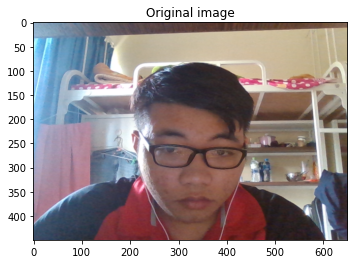

Database created and Successfully Connected to SQLite
Records created successfully
The SQLite connection is closed
opencv_frame.png written!
Found 1 validated image filenames belonging to 1 classes.
1/1 [==============================] - 0s 237ms/step
The result prediction is:
Tomatoes


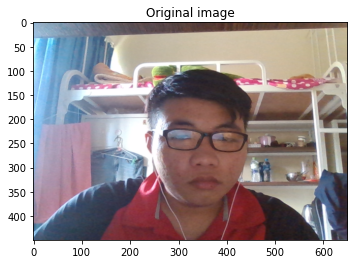

Database created and Successfully Connected to SQLite
Records created successfully
The SQLite connection is closed
opencv_frame.png written!
Found 1 validated image filenames belonging to 1 classes.
1/1 [==============================] - 0s 218ms/step
The result prediction is:
Apple


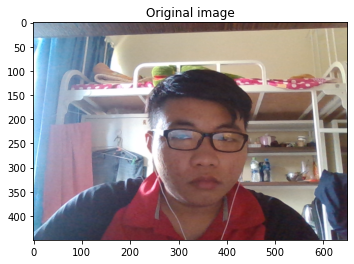

Database created and Successfully Connected to SQLite
Records created successfully
The SQLite connection is closed
opencv_frame.png written!
Found 1 validated image filenames belonging to 1 classes.
1/1 [==============================] - 0s 208ms/step
The result prediction is:
Apple


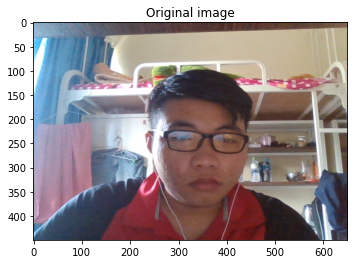

Database created and Successfully Connected to SQLite
Records created successfully
The SQLite connection is closed
opencv_frame.png written!
Found 1 validated image filenames belonging to 1 classes.
1/1 [==============================] - 0s 231ms/step
The result prediction is:
Apple


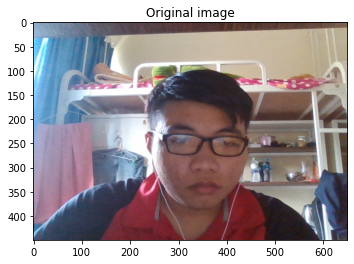

Database created and Successfully Connected to SQLite
Records created successfully
The SQLite connection is closed


In [12]:
def main():
    #Load pre-trained model
    X = load_model('mymodel.h5')
    camURL = "0"
    #create window
    window = MainWindow(camURL, X)
    window.mainloop()
    
if __name__ == "__main__":
    main()    